In [1]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import scipy.io.wavfile as wav
import scipy
from scipy import signal
from scipy import stats 
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import linear_cmap
import librosa
from scipy.interpolate import interp1d 
from fastdtw import fastdtw
import sklearn
import os
import soundfile as sf
import pandas as pd
import itertools 
from tabulate import tabulate


%matplotlib inline 
output_notebook()

Loading BokehJS ...

In [2]:
#file setup stuff

def load_audio(filename):
    
    # read in file and convert to range [-1, 1]:
    
    srate, audio = wav.read(filename)
    audio = audio.astype(np.float32) / 32767.0 
    
    # set max to 0.9:
    
    if (len(audio.shape) == 1): 
        audio = (0.9 / max(np.abs(audio)) * audio)
    else: 
        audio[:,0] = (0.9 / max(np.abs(audio[:,0])) * audio[:,0])
        audio[:,1] = (0.9 / max(np.abs(audio[:,1])) * audio[:,1])
        return audio.transpose(), srate
    
    # return audio:
    
    return audio, srate 

def trim(audio, amplitude_track, srate, binSize = 6, hopSize = 256, threshold = 2.5, sensitivity = 5):

    # get noise at beginning and end of audio clip: 
    
    begin_noise_level = np.mean(amplitude_track[:int(len(amplitude_track)/binSize)])
    end_noise_level   = np.mean(amplitude_track[-int(len(amplitude_track)/binSize):])
        
    index_first = None
    index_last  = None
    
    # if signal > threshold * begin_noise_level many times in a row, trim here (from track start):
    
    for i in range(len(amplitude_track)):
        if amplitude_track[i] > threshold * begin_noise_level:
            if all(amplitude_track[j] > threshold * begin_noise_level for j in range(i, i + sensitivity + 1)):
                index_first = i
                break
    
    # if signal > threshold * end_noise_level many times in a row, trim here (from track end):

    for i in range(len(amplitude_track)):
        if amplitude_track[i] > threshold * end_noise_level:
            if all(amplitude_track[j] > threshold * end_noise_level for j in range(i - sensitivity + 2, i + 1)):
                index_last = i
    
    return audio[index_first * hopSize:(index_last + 10) * hopSize]

def denoise(
    audio, 
    noise, 
    n_grad_freq   = 3,
    n_grad_time   = 4,
    n_fft         = 2048,
    win_length    = 2048,
    hop_length    = 512,
    n_std_thresh  = 1,
    prop_decrease = 1.0
):
    """
    
    Remove noise from audio based upon a clip containing only noise

    Args:
        audio (array)        : audio to denoise
        noise (array)        : noise sample
        n_grad_freq (int)    : how many frequency channels to smooth over with the mask.
        n_grad_time (int)    : how many time channels to smooth over with the mask.
        n_fft (int)          : number audio of frames between STFT columns.
        win_length (int)     : Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int)     : number audio of frames between STFT columns.
        n_std_thresh (int)   : how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal

    Returns:
        
        (array) The recovered signal with noise subtracted

    """

    # STFT over noise:
    
    stft_noise    = librosa.stft(y = noise, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    stft_noise_db = librosa.core.amplitude_to_db(np.abs(stft_noise))
    
    # calculate statistics over noise and noise threshold, over frequency axis:
    
    noise_freq_mean = np.mean(stft_noise_db, axis=1)
    noise_freq_std  = np.std(stft_noise_db, axis=1)
    noise_thresh    = noise_freq_mean + noise_freq_std * n_std_thresh
    
    # STFT over signal:

    stft_audio    = librosa.stft(y = audio, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    stft_audio_db = librosa.core.amplitude_to_db(np.abs(stft_audio))
    
    # calculate value to mask dB to:
    
    mask_gain_dB = np.min(stft_audio_db)
    
    # create a smoothing filter for the mask in time and frequency:
    
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    
    # calculate the threshold for each frequency/time bin:
    
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(noise_freq_mean)]),
        np.shape(stft_audio_db)[1],
        axis=0,
    ).T

    mask_audio = stft_audio_db < db_thresh

    # convolve the mask with a smoothing filter:
    
    mask_audio = scipy.signal.fftconvolve(mask_audio, smoothing_filter, mode = "same")
    mask_audio = mask_audio * prop_decrease

    # mask the signal:
    
    stft_audio_db_masked = (stft_audio_db * (1 - mask_audio) + np.ones(np.shape(mask_gain_dB)) 
                            * mask_gain_dB * mask_audio)
    
    # mask real:
    
    audio_imag_masked = np.imag(stft_audio) * (1 - mask_audio)
    stft_audio_amp = (librosa.core.db_to_amplitude(stft_audio_db_masked) * np.sign(stft_audio)) + (
        1j * audio_imag_masked
    )

    # recover the signal:
    
    recovered_signal = librosa.istft(stft_audio_amp, hop_length = hop_length, win_length = win_length)

    return recovered_signal

In [3]:
# Pitch detection 

def pitch_zero_crossings(frame, srate): 
    
    zero_indices   = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]
    pitch_estimate = (srate / np.mean(np.diff(zero_indices)))
    
    return pitch_estimate 

def pitch_fft(frame, srate): 
    
    mag            = np.abs(np.fft.fft(frame))
    mag            = mag[0:int(len(mag)/2)]
    pitch_estimate = np.argmax(mag) * (srate / len(frame))
    
    return pitch_estimate 

def pitch_autocorrelation(frame, srate):
    
    xcorrelation   = np.correlate(frame, frame, mode = 'full')
    derivative     = np.diff(xcorrelation[:int(len(xcorrelation)/2)+2])
    peak_indices   = np.nonzero((derivative[:-1] > 0) & (derivative[1:] <= 0))[0] + 1
    peak_values    = xcorrelation[peak_indices]
    peak_indices_sorted = peak_indices[np.argsort(peak_values)[-2:]]
    
    return srate/(peak_indices_sorted[1]-peak_indices_sorted[0])

def pitch_track(signal, hopSize, winSize, srate, extractor): 
    
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m, o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

        if (pitch_track[m] > 1500): 
            pitch_track[m] = 0 
    
    return (amp_track, pitch_track)

def sonify(amp_track, pitch_track, srate, hop_size):

    times = np.arange(0.0, float(hop_size * len(pitch_track)) / srate,
                      float(hop_size) / srate)

    # sample locations in time (seconds)                                                      
    sample_times = np.linspace(0, np.max(times), int(np.max(times)*srate-1))

    freq_interpolator = interp1d(times,pitch_track)
    amp_interpolator = interp1d(times,amp_track)
                                                                
    sample_freqs = freq_interpolator(sample_times)
    sample_amps  = amp_interpolator(sample_times)

    audio = np.zeros(len(sample_times))
    T = 1.0 / srate
    phase = 0.0
    
    for i in range(1, len(audio)):
        audio[i] = sample_amps[i] * np.sin(phase)
        phase = phase + (2*np.pi*T*sample_freqs[i])

    return audio


In [4]:
#Plotting stuff

def plot_time_domain(audio, srate): 
    p = figure(width=800, height=200, x_axis_label='Time (s)', y_axis_label='Amplitude')
    time = np.linspace(0, len(audio)/srate, num=len(audio))
    p.line(time, audio)
    show(p)

def plot_freq_domain(audio, srate):
    f, t, s = signal.spectrogram(audio, srate)
    s = 10 * np.log10(s + 1e-40)
    p = figure(width=800, height=400, x_axis_label='Time (s)', y_axis_label='Frequency (Hz)')
    p.image(image=[s], x=0, y=0, dw=t[-1], dh=f[-1], palette="Viridis256", level="image")
    show(p)

To evaluate how much and/or what kinds of variance exist within a given call type, we will break up
the calls of the type (from the pre-segmented Orchive) into a number of bins in the time domain, extract the estimated fundamental frequency per bin using the methods mentioned above, and examine the variations observed in between-bin differences. For example, consider a call type whose example calls are divided into four, equal-sized bins. Calls a, b, and c of this call type are found to have
fundamental frequencies per each bin as follows: (a) 2, 2, 2, 3, (b) 2, 2, 2, 1, and (c) 1, 1, 1, 2. By looking at the between-bin differences, for all three calls, there is only
a non-zero difference between bins 3 and 4. This is where our analysis would identify the presence of variation within this call type.
Of course, depending on age and sex, calls of a given
type will be naturally higher or lower in fundamental pitch
within even a familial group of orcas. It is likely then that
the intra-call variation in a call with some pitch x will dif-
fer markedly from the intra-call variation in the same call
with some pitch y, where x̸ = y, if between-bin differ-
ences are taken to be absolute subtractions. There is reason
to believe, as per the Weber-Fechner law [21], that ratios
are more important than absolute differences to matters of
perception. Therefore, we will likely look at between-bin
ratios, and not strictly between-bin differences. Further-
more, in order to account for the linguistic differences ob-
served throughout different pods and matrilineal lines, we
will either conduct this analysis on a per-pod basis pods to
account for variation between pods, or limit ourselves to
calls known to be shared between pods.

In [80]:
files = os.listdir('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/call-catalog/orig/wav')
#loop through all files, denoise, and trim:

for i in files:
    
    try: 
        # load audio:

        audio = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/call-catalog/orig/wav/'+i)

        # denoise:

        audio_denoised = denoise(audio[0], audio[0][:int(len(audio[0])/10)])

        # trim:

        audio_denoised_amp, audio_denoised_pitch  = pitch_track(audio_denoised, 256, 512, pitch_autocorrelation, audio[1])
        audio_denoised_trimmed = trim(audio_denoised, audio_denoised_amp, audio[1], sensitivity = 10)

        # output:

        sf.write('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+i, audio_denoised_trimmed, audio[1])

    except:
        pass

    #had to manually remove one file 

In [5]:
files = os.listdir('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata')

files_by_pod  = {x.split('-')[0]: [f for f in files if f.startswith(x.split('-')[0])] for x in files}
files_by_call = {x.split('-')[1]: [f for f in files if f.split('-')[1] == x.split('-')[1]] for x in files}

print(files_by_call)
print(files_by_pod)

{'honk': ['A04-honk-070706-D011-10255.wav', 'A04-honk-070706-D011-10359.wav', 'A11-honk-073106-D028-02110.wav', 'A24-honk-073107-D043-12329.wav'], 'N01': ['A04-N01-070706-D011-10403.wav', 'A11-N01-070806-D013-00132.wav', 'A11-N01-070806-D013-00205.wav', 'A12-N01-090206-D075-12550.wav', 'A12-N01-091904-D096-11541.wav', 'A24-N01-073107-D043-12617.wav', 'A30-N01-072806-D026-13433.wav', 'A30-N01-080606-D036-13529.wav', 'A30-N01-081306-D045-10304.wav', 'A34-N01-070806-D013-00038.wav', 'A34-N01-070806-D013-00525.wav', 'A34-N01-093006-D107-14004.wav', 'A34-N01-093006-D107-14010.wav', 'A36-N01-062802-D004-12218.wav', 'A36-N01-063002-D005-10943.wav', 'A36-N01-070806-D012-14021.wav', 'A36-N01-070806-D012-14025.wav', 'AI-N01-082906-D069-02201.wav', 'AI-N01-082906-D069-02203.wav', 'B07-N01-090406-D079-20013.wav', 'B07-N01-090406-D079-20024.wav', 'B07-N01-090604-D080-13923.wav', 'C-N01-070306-D008-14422.wav', 'C-N01-081601-D043-15952.wav', 'C06-N01-080110-D056-02121.wav', 'C10-N01-062902-D005-03118

In [6]:
#organizes list of call by podd (given a list of calls of a certain type)
def by_pod(files, pods):
    
    org_calls = {pod : [] for pod in pods}
    
    for file in files:
        p = file.split('-')[0]
        org_calls[p].append(file)

    return org_calls

In [7]:
n_one = files_by_call['N01']
unique_pods = np.unique([file.split('-')[0] for file in n_one])

n01_by_pod = by_pod(n_one, unique_pods)

In [8]:
audioc1,sratec1 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+n01_by_pod['A11'][0])
audioc2,sratec2 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+n01_by_pod['A11'][1])
print(n01_by_pod['A11'][0], n01_by_pod['A11'][1])

plot_time_domain(audioc1, sratec1)
ipd.Audio(audioc1, rate = sratec1)


A11-N01-070806-D013-00132.wav A11-N01-070806-D013-00205.wav


In [9]:
plot_time_domain(audioc2, sratec2)
ipd.Audio(audioc2, rate = sratec2)


**DTW Experiments**

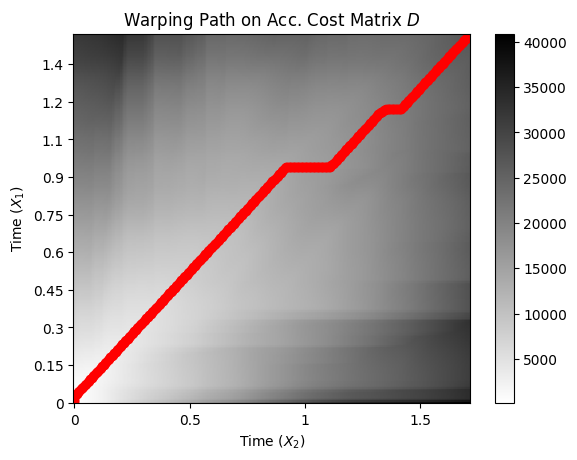

In [10]:
stft_1 = librosa.feature.mfcc(y=audioc1, sr = sratec1, hop_length= 256)
stft_2 = librosa.feature.mfcc(y=audioc2, sr = sratec2, hop_length= 256)

D, wp = librosa.sequence.dtw(X = stft_1, Y = stft_2, metric = 'euclidean')
wp_s = librosa.frames_to_time(wp, sr=sratec1, hop_length=256)

x1,x2 = D.shape


fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='time', sr=sratec1,
                               cmap='gray_r', hop_length=256, ax=ax)
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
ax.set(title='Warping Path on Acc. Cost Matrix $D$',
       xlabel='Time $(X_2)$', ylabel='Time $(X_1)$')
fig.colorbar(img, ax=ax)
plt.show()


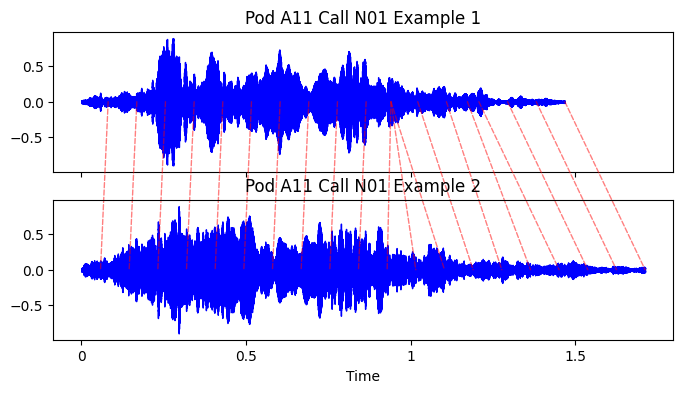

In [11]:
x_1 = audioc1
x_2 = audioc2
fs = sratec1

from matplotlib.patches import ConnectionPatch

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,4))

# Plot x_2
librosa.display.waveshow(x_2, sr=fs, ax=ax2, color = 'blue')
ax2.set(title='Pod A11 Call N01 Example 2')

# Plot x_1
librosa.display.waveshow(x_1, sr=fs, ax=ax1, color = 'blue')
ax1.set(title='Pod A11 Call N01 Example 1')
ax1.label_outer()


n_arrows = 20
for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
    # Create a connection patch between the aligned time points
    # in each subplot
    con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='--',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)
plt.show()

**DTW On Data**

In [13]:

#Looking at in pod variance for a call 
#Returns a dict in format pod : list of distances given list of calls sorted by type
def dtw_pod_stft(calls_by_type, win_size = 1024):
    
    pod_dict = {}

    for pod, calls in calls_by_type.items():
        
        distances = []
    
        #Calculate mean distance for each pod 
        # Each 
        if len(calls) > 1: 
            for call_one, call_two in itertools.combinations(calls, 2):
                
                a_1,sr_1 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_one)
                a_2,sr_2 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_two)

                stft_1 = librosa.feature.chroma_stft(y=a_1, sr = sr_1, tuning = 0, norm = 2, win_length = win_size, n_fft= 1024)
                stft_2 = librosa.feature.chroma_stft(y=a_2, sr = sr_2, tuning = 0, norm = 2, win_length = win_size, n_fft= 1024)

                D, wp = librosa.sequence.dtw(X = stft_1, Y = stft_2, metric = 'euclidean')
               
                distances.append(D[-1,-1])

            pod_dict[pod] = distances

    return pod_dict


#Look at global variance for a given call type 
#returns list of all distances for a give call type
def dtw_global_stft(calls, win_size = 1024):
    
    all_D = []

    for call_one, call_two in itertools.combinations(calls, 2):
        
        a_1,sr_1 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_one)
        a_2,sr_2 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_two)

        stft_1 = librosa.feature.chroma_stft(y=a_1, sr = sr_1, tuning = 0, norm = 2, win_length = win_size, n_fft= 1024)
        stft_2 = librosa.feature.chroma_stft(y=a_2, sr = sr_2, tuning = 0, norm = 2, win_length = win_size, n_fft= 1024)

        D, wp = librosa.sequence.dtw(X = stft_1, Y = stft_2, metric = 'euclidean')
    
        all_D.append(D[-1,-1])

    return all_D 



#DTW using mfcc features 

def dtw_pod_mfcc(calls_by_type, win_size = 1024):
    pod_dict = {}

    for pod, calls in calls_by_type.items():

        distances = []    
        #Compare each call in pod to every other call in pod 
        if len(calls) > 1: 
            for call_one, call_two in itertools.combinations(calls, 2):

                a_1,sr_1 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_one)
                a_2,sr_2 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_two)

                mfcc_1 = librosa.feature.mfcc(y=a_1, sr = sr_1, win_length = win_size, n_fft= 1024)
                mfcc_2 = librosa.feature.mfcc(y=a_2, sr = sr_2, win_length = win_size, n_fft= 1024)

                D, wp = librosa.sequence.dtw(X = mfcc_1, Y = mfcc_2, metric = 'euclidean')
               
                distances.append(D[-1,-1])

            pod_dict[pod] = distances

    return pod_dict

def dtw_global_mfcc(calls, win_size = 1024):
    
    all_D = []

    for call_one, call_two in itertools.combinations(calls, 2):
        
        a_1,sr_1 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_one)
        a_2,sr_2 = load_audio('C:/Users/Sasha King/Documents/UVic/CSC 475/Project/Data/prettydata/'+call_two)

        
        mfcc_1 = librosa.feature.mfcc(y=a_1, sr = sr_1, win_length = win_size, n_fft= 1024)
        mfcc_2 = librosa.feature.mfcc(y=a_2, sr = sr_2, win_length = win_size, n_fft= 1024)


        D, wp = librosa.sequence.dtw(X = mfcc_1, Y = mfcc_2, metric = 'euclidean')

        #what to do with this warp path???
        
        all_D.append(D[-1,-1])

    return all_D 




In [14]:
for key in n01_by_pod:    
    print(key, n01_by_pod[key])

A04 ['A04-N01-070706-D011-10403.wav']
A11 ['A11-N01-070806-D013-00132.wav', 'A11-N01-070806-D013-00205.wav']
A12 ['A12-N01-090206-D075-12550.wav', 'A12-N01-091904-D096-11541.wav']
A24 ['A24-N01-073107-D043-12617.wav']
A30 ['A30-N01-072806-D026-13433.wav', 'A30-N01-080606-D036-13529.wav', 'A30-N01-081306-D045-10304.wav']
A34 ['A34-N01-070806-D013-00038.wav', 'A34-N01-070806-D013-00525.wav', 'A34-N01-093006-D107-14004.wav', 'A34-N01-093006-D107-14010.wav']
A36 ['A36-N01-062802-D004-12218.wav', 'A36-N01-063002-D005-10943.wav', 'A36-N01-070806-D012-14021.wav', 'A36-N01-070806-D012-14025.wav']
AI ['AI-N01-082906-D069-02201.wav', 'AI-N01-082906-D069-02203.wav']
B07 ['B07-N01-090406-D079-20013.wav', 'B07-N01-090406-D079-20024.wav', 'B07-N01-090604-D080-13923.wav']
C ['C-N01-070306-D008-14422.wav', 'C-N01-081601-D043-15952.wav']
C06 ['C06-N01-080110-D056-02121.wav']
C10 ['C10-N01-062902-D005-03118.wav', 'C10-N01-072307-D033-34220.wav']
D ['D-N01-081998-D024-20159.wav', 'D-N01-082604-D074-14108

In [15]:
#look at in pod variance for N01
dist_by_pod_mfcc = dtw_pod_mfcc(n01_by_pod)

In [16]:
print(dist_by_pod_mfcc)

properties = []
for pod, dlist in dist_by_pod_mfcc.items():
    features = (pod, np.mean(dlist), np.std(dlist), len(dlist))
    properties.append(features)

print(tabulate(properties, headers = ['Pod', 'Mean Distance', 'STD', 'Num Samples']))

{'A11': [13654.312300636948], 'A12': [21775.690979421495], 'A30': [24359.794252989777, 20540.62358335931, 15569.144419045968], 'A34': [17442.10877230067, 19358.834794347607, 23586.32149394348, 23849.62730948523, 27211.112602255736, 13460.16631340479], 'A36': [16635.02332989582, 12838.29283408989, 14293.088305200661, 11339.910555314236, 14405.516505858024, 10044.874455683317], 'AI': [15956.984166525395], 'B07': [23111.10585614584, 14121.505290578822, 25083.09712868136], 'C': [16983.764151466905], 'C10': [10964.429817818735], 'D': [19111.13107315217], 'H': [15882.941967173345], 'I18': [23821.711921540198]}
Pod      Mean Distance      STD    Num Samples
-----  ---------------  -------  -------------
A11            13654.3     0                 1
A12            21775.7     0                 1
A30            20156.5  3599.03              3
A34            20818    4571.47              6
A36            13259.5  2159.16              6
AI             15957       0                 1
B07         

In [17]:
dist_by_pod_stft = dtw_pod_stft(n01_by_pod)

In [18]:
print(dist_by_pod_stft)

properties = []
for pod, dlist in dist_by_pod_stft.items():
    features = (pod, np.mean(dlist), np.std(dlist), len(dlist))
    properties.append(features)

print(tabulate(properties, headers = ['Pod', 'Mean Distance', 'STD', 'Num Samples']))

{'A11': [52.83450897318305], 'A12': [97.44779348712396], 'A30': [107.793466738092, 92.4359911975494, 88.86529240538195], 'A34': [106.65518816825563, 181.99725872193952, 205.86287087629415, 166.36750796205766, 200.76797703697605, 93.6441897521811], 'A36': [92.68455988032747, 63.02652610560958, 64.54313874554693, 64.34171426527519, 88.2074214774108, 54.681579412344846], 'AI': [127.71927742420937], 'B07': [80.1220331229322, 113.10452632099823, 156.94817647462432], 'C': [130.73355275536977], 'C10': [95.64396754701936], 'D': [88.35075764843792], 'H': [69.88203934310236], 'I18': [145.48998941769597]}
Pod      Mean Distance       STD    Num Samples
-----  ---------------  --------  -------------
A11            52.8345   0                    1
A12            97.4478   0                    1
A30            96.3649   8.21163              3
A34           159.216   43.8462               6
A36            71.2475  14.0347               6
AI            127.719    0                    1
B07           

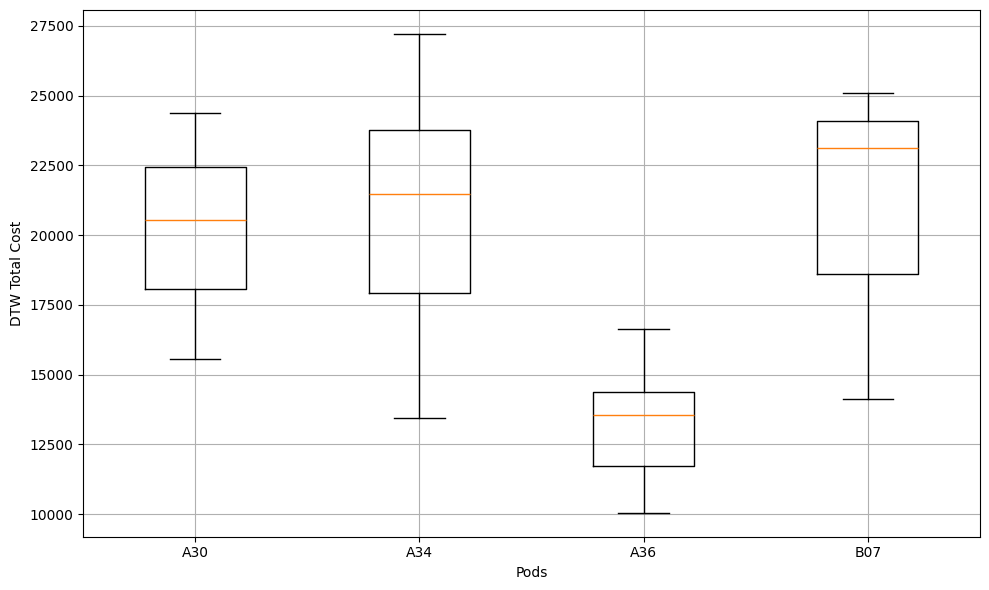

In [19]:
#box plot for inpod variance 

fig, ax1 = plt.subplots(figsize = (10, 6))
fig.canvas.manager.set_window_title('In Pod Call Variance')
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

pods = []
plot_list = []

for index, key in enumerate(dist_by_pod_mfcc):
    
    dist_list = dist_by_pod_mfcc[key]
    if len(dist_list) > 2:
        pods.append(key)
        plot_list.append(dist_list)

plt.boxplot(plot_list)   


plt.grid(True)

ax1.set(
    axisbelow=True,
    xlabel='Pods',
    ylabel='DTW Total Cost',
)

ax1.set_xticklabels(pods)
fig.tight_layout()


plt.show()

In [20]:
#Takes dict of samples of form pod: list of distances 
#Compares all smaples with size > 2
#Outputs dict of form (Pod A, Pod B): ks_test result
def Ks_test(samples):
    pods = [key for key in samples if len(samples[key])> 2]
    distances = [d for d in samples.values() if len(d) > 2]
    r = range(len(distances))
    res = {}
    for a,b in itertools.combinations(r, 2):
       res[pods[a], pods[b]] = stats.ks_2samp(distances[a], distances[b])
    return res

In [21]:
print(dist_by_pod_mfcc)

{'A11': [13654.312300636948], 'A12': [21775.690979421495], 'A30': [24359.794252989777, 20540.62358335931, 15569.144419045968], 'A34': [17442.10877230067, 19358.834794347607, 23586.32149394348, 23849.62730948523, 27211.112602255736, 13460.16631340479], 'A36': [16635.02332989582, 12838.29283408989, 14293.088305200661, 11339.910555314236, 14405.516505858024, 10044.874455683317], 'AI': [15956.984166525395], 'B07': [23111.10585614584, 14121.505290578822, 25083.09712868136], 'C': [16983.764151466905], 'C10': [10964.429817818735], 'D': [19111.13107315217], 'H': [15882.941967173345], 'I18': [23821.711921540198]}


In [22]:
res_stft = Ks_test(dist_by_pod_stft)
for key,item in res_stft.items():
    print(key, item)

('A30', 'A34') KstestResult(statistic=0.6666666666666666, pvalue=0.3333333333333333, statistic_location=107.793466738092, statistic_sign=1)
('A30', 'A36') KstestResult(statistic=0.8333333333333334, pvalue=0.09523809523809525, statistic_location=88.2074214774108, statistic_sign=-1)
('A30', 'B07') KstestResult(statistic=0.6666666666666666, pvalue=0.6, statistic_location=107.793466738092, statistic_sign=1)
('A34', 'A36') KstestResult(statistic=1.0, pvalue=0.0021645021645021645, statistic_location=92.68455988032747, statistic_sign=-1)
('A34', 'B07') KstestResult(statistic=0.6666666666666666, pvalue=0.3333333333333333, statistic_location=156.94817647462432, statistic_sign=-1)
('A36', 'B07') KstestResult(statistic=0.6666666666666666, pvalue=0.3333333333333333, statistic_location=92.68455988032747, statistic_sign=1)


In [23]:
res_mfcc = Ks_test(dist_by_pod_mfcc)
for key, item in res_mfcc.items():
    print(key, item)

('A30', 'A34') KstestResult(statistic=0.16666666666666666, pvalue=1.0, statistic_location=23849.62730948523, statistic_sign=-1)
('A30', 'A36') KstestResult(statistic=0.8333333333333334, pvalue=0.09523809523809525, statistic_location=14405.516505858024, statistic_sign=-1)
('A30', 'B07') KstestResult(statistic=0.3333333333333333, pvalue=1.0, statistic_location=24359.794252989777, statistic_sign=1)
('A34', 'A36') KstestResult(statistic=0.8333333333333334, pvalue=0.025974025974025972, statistic_location=16635.02332989582, statistic_sign=-1)
('A34', 'B07') KstestResult(statistic=0.16666666666666666, pvalue=1.0, statistic_location=23849.62730948523, statistic_sign=1)
('A36', 'B07') KstestResult(statistic=0.6666666666666666, pvalue=0.3333333333333333, statistic_location=16635.02332989582, statistic_sign=1)


In [24]:
#Lets look at global n01
global_call = dtw_global_mfcc(n_one)

In [25]:
#some stats for global call variance regarding N01

print("Mean",np.mean(global_call))
print("STD",np.std(global_call))


Mean 22080.55020003521
STD 4877.862187251556


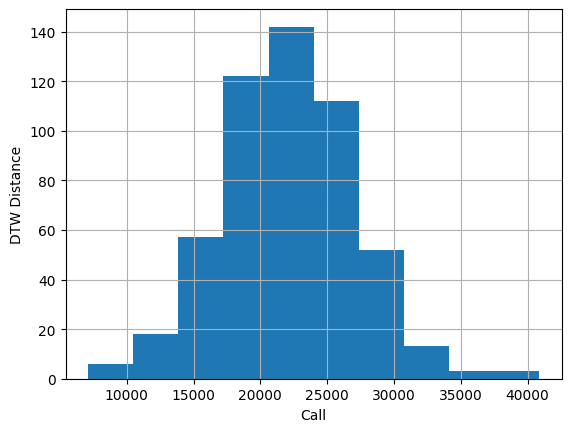

In [26]:
plt.hist(global_call)
plt.grid(True)
plt.xlabel('Call')
plt.ylabel('DTW Distance')
plt.show()

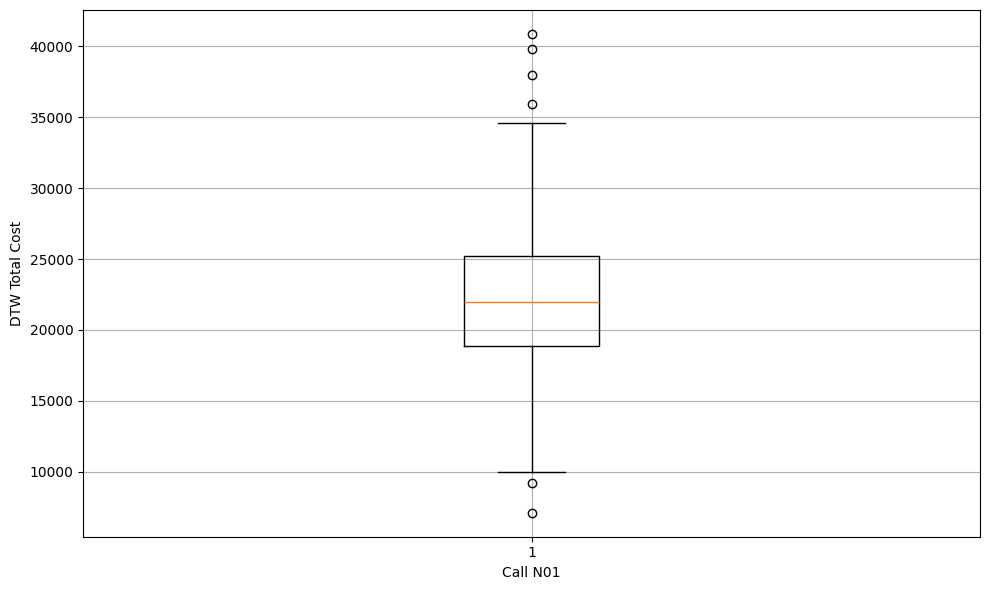

In [28]:
#boxplot for global varaince in a call

fig, ax1 = plt.subplots(figsize = (10, 6))
fig.canvas.manager.set_window_title('Global Variance for Call n01')
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


plt.boxplot(global_call)   
plt.grid(True)

ax1.set(
    axisbelow=True,
    xlabel='Call N01',
    ylabel='DTW Total Cost',
)

fig.tight_layout()
plt.show()
